In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import savemat
import matplotlib.pyplot as plt
from src.dataloader.transforms import BandPassFilter, Spline_interpolation

In [2]:
from collections import Counter

In [3]:
IN_DIR = "hefei"
OUT_BASE = "data"
OUT_SPLIT = "split_csvs"
OUT_ECGS = "processed_data"
DS_NAME = "Hefei"

Einthoven's law: lead I + lead III = lead II

Goldberger's equations:
*   aVL = (lead I - lead III) / 2
*   -aVR = (lead I + lead II) / 2
*   aVF = (lead II + lead III) / 2   

In [4]:
LEAD_ORDER = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

In [5]:
def txt8leadto12lead(fn):
    df = pd.read_csv(fn, sep=" ").astype("float64")
    df["III"] = df["II"] - df["I"]
    df["aVL"] = (df["I"] - df["III"]) / 2
    df["aVR"] = -((df["I"] + df["II"]) / 2)
    df["aVF"] = (df["II"] + df["III"]) / 2
    return df[LEAD_ORDER]

In [6]:
ECG_DIR = os.path.join(IN_DIR, "hf_round2_train")

## Test

In [17]:
df = txt8leadto12lead(os.path.join(ECG_DIR, "100001.txt"))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   I       5000 non-null   float64
 1   II      5000 non-null   float64
 2   III     5000 non-null   float64
 3   aVR     5000 non-null   float64
 4   aVL     5000 non-null   float64
 5   aVF     5000 non-null   float64
 6   V1      5000 non-null   float64
 7   V2      5000 non-null   float64
 8   V3      5000 non-null   float64
 9   V4      5000 non-null   float64
 10  V5      5000 non-null   float64
 11  V6      5000 non-null   float64
dtypes: float64(12)
memory usage: 468.9 KB


In [32]:
xx = df.to_numpy()

In [33]:
xx.shape

(5000, 12)

In [34]:
x = np.arange(xx.shape[0])

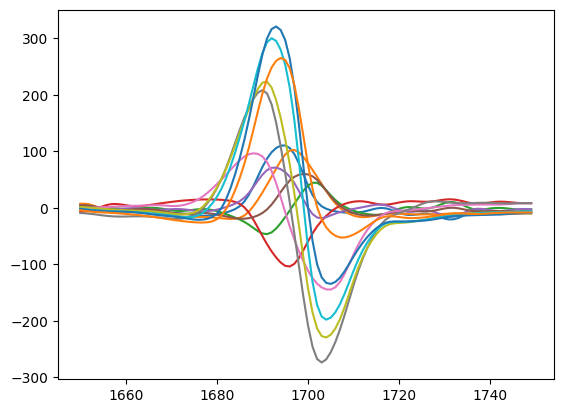

In [44]:
for j in range(xx.shape[-1]):
    plt.plot(x[1650:1750], xx[1650:1750, j])

In [46]:
bpf = BandPassFilter(fs=400)
ecg = bpf(xx.T)

In [47]:
ecg.shape

(12, 5000)

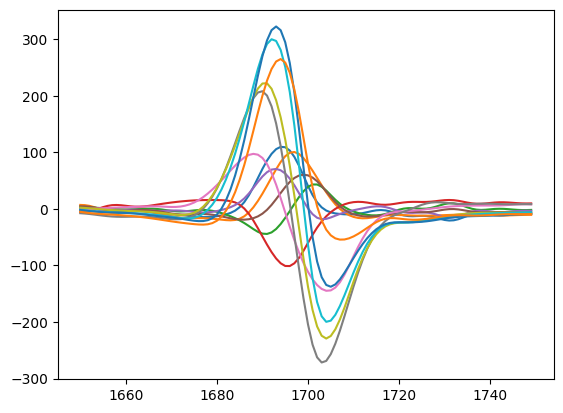

In [48]:
for j in range(ecg.shape[0]):
    plt.plot(x[1650:1750], ecg[j, 1650:1750])

In [49]:
si = Spline_interpolation(fs_new=250, fs_old=400)
ecg = si(ecg)

In [50]:
ecg.shape

(12, 3125)

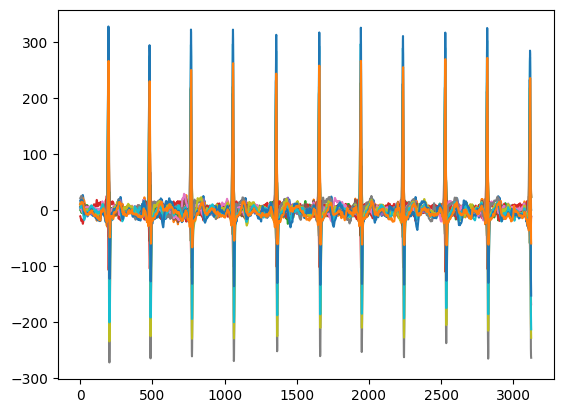

In [51]:
for j in range(ecg.shape[0]):
    plt.plot(x[:ecg.shape[1]], ecg[j, :])

## Class mappings

/home/zoorab/12-lead-ecg-classifier/data/processed_data/CPSC_CPSC_Extra/A0244_preprocessed.mat,62,Female,250,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
The  csv files  all have 6 columns 1dAVb, RBBB, LBBB, SB, AF, ST
path,age,gender,fs,426783006,426177001,164934002,427393009,713426002,427084000,59118001,164889003,59931005,47665007,445118002,39732003,164890007,164909002,270492004,251146004,284470004
e.g. all "prolonged pr interval" will be merged to "1st degree heart block" (Physionet mapping)
first_degree_hb_snomed = '270492004'
prolonged_pr_snomed = '164947007'

In [7]:
rename2snomed = {
    "窦性心律": "426783006",
    "窦性心动过缓": "426177001",
    "窦性心动过速": "427084000",
    "T波改变": "label01",
    "电轴右偏": "47665007",
    "电轴左偏": "39732003",
    "窦性心律不齐": "427393009",
    "右束支传导阻滞": "59118001",
    "室性早搏": "17338001",
    "完全性右束支传导阻滞": "713427006",
    "左心室高电压": "label02",
    "房性早搏": "284470004",
    "ST-T改变": "label03",
    "ST段改变": "label04",
    "一度房室传导阻滞": "270492004",
    "不完全性右束支传导阻滞": "713426002",
    "心房颤动": "164889003",
    "非特异性ST段异常": "label05",
    "逆钟向转位": "label06",
    "下壁异常Q波": "label07",
    "顺钟向转位": "label08",
    "左前分支传导阻滞": "445118002",
    "非特异性T波异常": "label09",
    "右心房扩大": "label10",
    "快心室率": "label11",
    "完全性左束支传导阻滞": "label12",
    "左束支传导阻滞": "164909002",
    "短PR间期": "49578007",
    "早期复极化": "label14",
    "前间壁R波递增不良": "label15",
    "起搏心律": "label16",
    "非特异性ST段与T波异常": "label17",
    "融合波": "label18",
    "QRS低电压": "251146004"
}

In [8]:
pretrained_header = ['path', 'age', 'gender', 'fs',
              '426783006', '426177001', '164934002', '427393009',
              '713426002', '427084000', '59118001', '164889003',
              '59931005', '47665007', '445118002', '39732003',
              '164890007', '164909002', '270492004', '251146004', '284470004']

In [9]:
labels = {}
with open(os.path.join(IN_DIR, "hf_round2_train.txt")) as f:
    for l in f:
        parts = l.split("\t")
        in_fn = parts[0]
        labels[in_fn] = [label for label in parts[3:] if len(label.strip()) > 1]

In [10]:
len(labels)

20036

In [11]:
label_cnt = Counter()
for v in labels.values():
    for vv in v:
        label_cnt[vv] += 1

In [12]:
label_cnt.most_common(32)

[('窦性心律', 9501),
 ('窦性心动过缓', 5264),
 ('窦性心动过速', 4895),
 ('T波改变', 3479),
 ('电轴右偏', 1124),
 ('电轴左偏', 1124),
 ('窦性心律不齐', 901),
 ('右束支传导阻滞', 551),
 ('室性早搏', 543),
 ('完全性右束支传导阻滞', 418),
 ('左心室高电压', 414),
 ('房性早搏', 314),
 ('ST-T改变', 299),
 ('ST段改变', 286),
 ('一度房室传导阻滞', 142),
 ('不完全性右束支传导阻滞', 126),
 ('心房颤动', 120),
 ('非特异性ST段异常', 64),
 ('逆钟向转位', 60),
 ('下壁异常Q波', 52),
 ('顺钟向转位', 35),
 ('左前分支传导阻滞', 35),
 ('非特异性T波异常', 34),
 ('右心房扩大', 32),
 ('快心室率', 29),
 ('完全性左束支传导阻滞', 25),
 ('左束支传导阻滞', 25),
 ('短PR间期', 23),
 ('早期复极化', 22),
 ('前间壁R波递增不良', 16),
 ('起搏心律', 16),
 ('非特异性ST段与T波异常', 16)]

In [14]:
csv_header = ['path', 'age', 'gender', 'fs']

In [15]:
label_pos = {}
for i, (txt, _) in enumerate(label_cnt.most_common(32)):
    label_pos[txt] = i
    csv_header.append(rename2snomed[txt])

Header for the larger 32-class set

In [16]:
csv_header

['path',
 'age',
 'gender',
 'fs',
 '426783006',
 '426177001',
 '427084000',
 'label01',
 '47665007',
 '39732003',
 '427393009',
 '59118001',
 '17338001',
 '713427006',
 'label02',
 '284470004',
 'label03',
 'label04',
 '270492004',
 '713426002',
 '164889003',
 'label05',
 'label06',
 'label07',
 'label08',
 '445118002',
 'label09',
 'label10',
 'label11',
 'label12',
 '164909002',
 '49578007',
 'label14',
 'label15',
 'label16',
 'label17']

In [17]:
label_pos_pretrain = {}
rev_map = dict((v, k) for k, v in rename2snomed.items())
for i, label in enumerate(pretrained_header[4:]):
    if label in rev_map:
        label_pos_pretrain[rev_map[label]] = i

## Round 2 training set

In [18]:
mat_path = os.path.join(OUT_BASE, OUT_ECGS, DS_NAME)
os.makedirs(mat_path, exist_ok=True)

In [19]:
bpf = BandPassFilter(fs=500)
si = Spline_interpolation(fs_new=250, fs_old=500)

In [20]:
in_files = os.listdir(ECG_DIR)

In [21]:
len(in_files)

20036

In [22]:
in_files[0]

'116539.txt'

In [23]:
out_file_idx = {}
for in_fn in in_files:
    df = txt8leadto12lead(os.path.join(ECG_DIR, in_fn))
    ecg = bpf(df.to_numpy().T)
    ecg = si(ecg)
    out_fn = os.path.join(mat_path, in_fn.replace(".txt", ".mat"))
    savemat(out_fn, {"val" : ecg})
    out_file_idx[in_fn] = out_fn

In [24]:
len(out_file_idx)

20036

In [25]:
in_fn_list = []
age_list = []
sex_list = []
with open(os.path.join(IN_DIR, "hf_round2_train.txt")) as f:
    for l in f:
        parts = l.split("\t")
        in_fn, age, sex = parts[:3]
        if not (age and sex):
            continue
        in_fn_list.append(in_fn)
        age_list.append(int(age))
        sex_list.append("Male" if sex == "MALE" else "Female")

In [26]:
df = pd.DataFrame(data={"path": [out_file_idx[in_fn] for in_fn in in_fn_list],
                        "age": age_list,
                        "gender": sex_list})

In [27]:
df.shape

(18444, 3)

In [28]:
df["fs"] = 250

In [29]:
df.head()

,path,age,gender,fs
0,data/processed_data/Hefei/100001.mat,47,Male,250
1,data/processed_data/Hefei/100003.mat,40,Male,250
2,data/processed_data/Hefei/100005.mat,42,Male,250
3,data/processed_data/Hefei/100007.mat,21,Female,250
4,data/processed_data/Hefei/100009.mat,49,Male,250


32 labels (2 labels with less than 10 instances skipped)

In [30]:
labels_lil = []
for in_fn in in_fn_list:
    labels_rec = [0] * 32
    for txt in labels[in_fn]:
        if txt in label_pos:
            labels_rec[label_pos[txt]] = 1
    labels_lil.append(labels_rec)


In [31]:
df2 = pd.DataFrame(np.array(labels_lil), columns=csv_header[4:])

In [32]:
df2.head()

,426783006,426177001,427084000,label01,47665007,39732003,427393009,59118001,17338001,713427006,...,label09,label10,label11,label12,164909002,49578007,label14,label15,label16,label17
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df2.sum()

426783006    8494
426177001    4955
427084000    4620
label01      3445
47665007     1098
39732003     1113
427393009     840
59118001      542
17338001      536
713427006     417
label02       379
284470004     307
label03       296
label04       272
270492004     136
713426002     118
164889003     120
label05        50
label06        58
label07        51
label08        35
445118002      35
label09        24
label10        26
label11        29
label12        25
164909002      25
49578007       21
label14        18
label15        16
label16        16
label17        14
dtype: int64

In [34]:
df_32 = df.merge(df2, left_index=True, right_index=True)

In [35]:
df_32[csv_header].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18444 entries, 0 to 18443
Data columns (total 36 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       18444 non-null  object
 1   age        18444 non-null  int64 
 2   gender     18444 non-null  object
 3   fs         18444 non-null  int64 
 4   426783006  18444 non-null  int64 
 5   426177001  18444 non-null  int64 
 6   427084000  18444 non-null  int64 
 7   label01    18444 non-null  int64 
 8   47665007   18444 non-null  int64 
 9   39732003   18444 non-null  int64 
 10  427393009  18444 non-null  int64 
 11  59118001   18444 non-null  int64 
 12  17338001   18444 non-null  int64 
 13  713427006  18444 non-null  int64 
 14  label02    18444 non-null  int64 
 15  284470004  18444 non-null  int64 
 16  label03    18444 non-null  int64 
 17  label04    18444 non-null  int64 
 18  270492004  18444 non-null  int64 
 19  713426002  18444 non-null  int64 
 20  164889003  18444 non-null  i

In [36]:
csv_path = os.path.join(OUT_BASE, OUT_SPLIT, DS_NAME)
os.makedirs(csv_path, exist_ok=True)

In [37]:
df_32[csv_header].to_csv(os.path.join(csv_path, "ecgs_32classes.csv"), index=None, sep=',')

In [38]:
df_small = df_32.sample(frac=0.1)

In [39]:
df_small[csv_header].to_csv(os.path.join(csv_path, "ecgs_32classes_10.csv"), index=None, sep=',')

Dataset that is compatible with pretrained 17-class models
(classes have same column positions but may be 0-s if not present in Hefei)

In [40]:
labels_lil_pt = []
for in_fn in in_fn_list:
    labels_rec = [0] * 17
    for txt in labels[in_fn]:
        if txt in label_pos_pretrain:
            labels_rec[label_pos_pretrain[txt]] = 1
    labels_lil_pt.append(labels_rec)

In [41]:
df3 = pd.DataFrame(np.array(labels_lil_pt), columns=pretrained_header[4:])

In [42]:
df_pt = df.merge(df3, left_index=True, right_index=True)

In [43]:
csv_path = os.path.join(OUT_BASE, OUT_SPLIT, DS_NAME + "_compat")
os.makedirs(csv_path, exist_ok=True)

Also run
```
ln -s Hefei Hefei_compat
```
in the processed data directory

In [44]:
df_pt[pretrained_header].to_csv(os.path.join(csv_path, "ecgs_pretrained_compatible.csv"), index=None, sep=',')

In [45]:
df_small = df_pt.sample(frac=0.1)

In [46]:
df_small[pretrained_header].to_csv(os.path.join(csv_path, "ecgs_pretrained_compatible_10.csv"), index=None, sep=',')